# Handwritten Text Recognition - OCR - CNN

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

import random
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

from keras.preprocessing.image import load_img, save_img

Using TensorFlow backend.


In [2]:
# Data Acquisition
# DATA = "../data/raw"
# LETS = list("SINO")

DATA = "../data/ImageGenerator"
LETS = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
NUM_LETS = len(LETS)
IMG_SIZE = 100
model_path = "../data/model"
model_name = f"model_full{NUM_LETS}_800"
model_name

'model_full26_800'

In [3]:
# Turns images into black and white
def black_and_white(image, threshold):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)[1]
    #thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, threshold, 1)
    kernel = np.ones((2,2))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    return closing

In [4]:
def load_letters(path, letters_list, img_size=100):
    print("Loading data...")
    letters = []
    # Looping through each letter folder
    for let in letters_list:
        images = os.listdir(os.path.join(path, let))
        # Looping through each image within a specific letter folder
        for pic in images:
            # Reading, resizing and turning the image into grayscale
            img = cv2.imread(os.path.join(path, let, pic))
            resized = cv2.resize(img, (img_size, img_size))
            
            gblur = cv2.GaussianBlur(resized, (5,5), 0) # removes high frequency noise
            
            thresh = black_and_white(gblur, 120)
            
            
#           if let == "A":
#             cv2.imwrite(f"{DATA}/{let}-{pic}", thresh)
                
            # Saving letter image array and target into a list
            letters.append([thresh, letters_list.index(let)])


    print(f"Total images: {len(letters)}")
    return letters
        
letters = load_letters(DATA, LETS, IMG_SIZE)
print(len(letters))

Loading data...
Total images: 20800
20800


In [5]:
# Checking how many images were read per letter
def check_loaded_data(loaded_letters_list, individual_letters_list):
    y = [target[1] for target in loaded_letters_list]
    res = [[letter, y.count(individual_letters_list.index(letter))] for letter in individual_letters_list]
    #res = [[letter, y.count(letter)] for letter in individual_letters_list]
    print(len(res))
    print(res)

check_loaded_data(letters, LETS)

26
[['A', 800], ['B', 800], ['C', 800], ['D', 800], ['E', 800], ['F', 800], ['G', 800], ['H', 800], ['I', 800], ['J', 800], ['K', 800], ['L', 800], ['M', 800], ['N', 800], ['O', 800], ['P', 800], ['Q', 800], ['R', 800], ['S', 800], ['T', 800], ['U', 800], ['V', 800], ['W', 800], ['X', 800], ['Y', 800], ['Z', 800]]


In [6]:
# Checking loaded images
def shuffle(list_to_shuffle):
    random.shuffle(list_to_shuffle)
    return list_to_shuffle

shuffled = shuffle(letters)
print(len(shuffled))

20800


In [7]:
def prep_data(training_data):
    """
    Preparing the data that will be used to feed the model
    :param training_data: 
    :return: 
    """
    X, y = [], []
    # Splitting data into traning data (X) and its label or target (y)
    for features, label in training_data:
        X.append(features)
        y.append(label)
        
    # Converting y list into a categorical array, 0 and 1. It will have as many columns as letters to train
    y = tf.keras.utils.to_categorical(y, len(LETS))
    
    # Converting X list into a keras array ready to be used to train the model
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # 1 grayscale
    
    # Normalizing training data
    #X = tf.keras.utils.normalize(X, axis=1)
    X = X/255
    print(X.shape, y.shape)

    return X, y

X, y = prep_data(shuffled)

(20800, 100, 100, 1) (20800, 26)


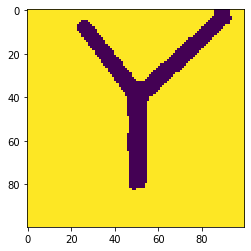

In [8]:
plt.imshow(X[0].reshape(100,100))

In [9]:
def model_setup(X, y, letters_list):

    # Model's name
    NAME = f"OCR-CNN-{int(time.time())}"
    print(NAME)

    # Model instantiation and layers definition
    model = Sequential() # instatiating the NN

    # Adding first 2D convolution layer
    model.add(Conv2D(64, (3,3), input_shape=X.shape[1:], activation="relu")) # X.shape[1:] → (100, 100, 1)
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # Adding second 2D convolution layer
    model.add(Conv2D(64, (3,3), activation="relu"))# don't have to specify input shape in additional layers.
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # Adding third 2D convolution layer
    model.add(Conv2D(64, (3,3), activation="relu"))# don't have to specify input shape in additional layers.
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # Flattening before passing it to the dense layer
    model.add(Flatten())

    # Adding output layer, as many units as letters there are, activation softmax
    model.add(Dense(len(letters_list), activation="softmax"))

    # Setting up tensorboard logs
    tb = TensorBoard(log_dir=f"../data/logs/{NAME}")

    # Model parameters
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    
    # Model summary
    model.summary()
    
    # Model fitting
    hist = model.fit(X, y, batch_size=32, epochs=5, validation_split=0.2, callbacks=[tb])
    
    return model, hist
    
model, hist = model_setup(X, y, LETS)

OCR-CNN-1587506988
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2

In [11]:
# saving the model
def save_model_h5(model, model_path, model_name):
    model.save(os.path.join(model_path, f"{model_name}.h5"))
    print(f"Saved model to {model_path}/{model_name}.h5")
    
save_model_h5(model, model_path, model_name)

Saved model to ../data/model/model_full26_800.h5


In [12]:
# loading the model
def load_model_h5(model_path, model_name):
    try:
        # Loading H5 file
        print(os.path.join(model_path, f"{model_name}.h5"))
        loaded_model = load_model(os.path.join(model_path, f"{model_name}.h5"))
        print("Model loaded successfully")
        return loaded_model
    except  Exception as e:
        print("Model couldn't be loaded. Did you import keras load_model function?")


loaded_model = load_model_h5(model_path, model_name)

../data/model/model_full26_800.h5
Model loaded successfully


Model perfomance chart was successfully saved at: model_full26_800-performance.png


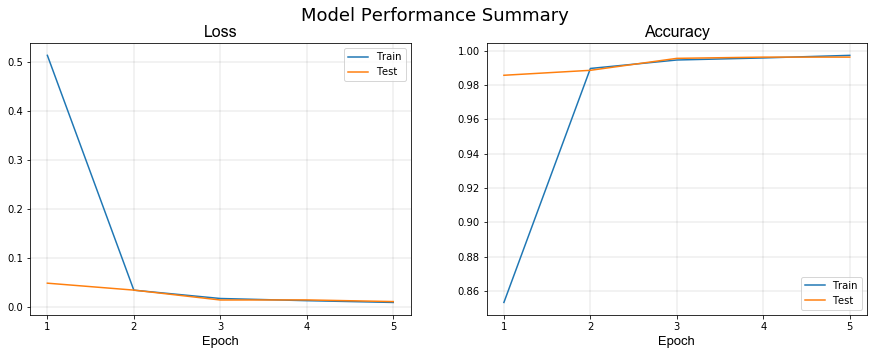

In [13]:
def plot_performance(hist, model_name):

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle("Model Performance Summary", fontsize=18)
    
    x_ticks = np.arange(1, len(hist.history["loss"]) + 1)
    
    label_font = {"fontname" : "Arial", "fontsize": 13}
    title_font = {"fontname" : "Arial", "fontsize": 16}
    
    axes[0].set_title("Loss", fontdict=title_font)
    axes[0].set_xlabel("Epoch", fontdict=label_font)
    axes[0].set_xticks(np.arange(len(x_ticks)))
    axes[0].set_xticklabels(x_ticks)
    axes[0].plot(hist.history["loss"], label="Train")
    axes[0].plot(hist.history["val_loss"], label="Test")
    axes[0].grid(True, color="black", linewidth=0.1)
    axes[0].legend()

    axes[1].set_title("Accuracy", fontdict=title_font)
    axes[1].set_xlabel("Epoch", fontdict=label_font)
    axes[1].set_xticks(np.arange(len(x_ticks)))
    axes[1].set_xticklabels(x_ticks)
    axes[1].plot(hist.history["accuracy"], label="Train")
    axes[1].plot(hist.history["val_accuracy"], label="Test")
    axes[1].legend(loc=4)
    axes[1].grid(True, color="black", linewidth=0.1)
    
    try:
        plt.savefig(f"{model_name}-performance.png")
        print(f"Model perfomance chart was successfully saved at: {model_name}-performance.png")
    except Exception as e:
        print("Error saving model chart")

plot_performance(hist, model_name)

In [14]:
loss, acc = model.evaluate(X, y)

20800/20800 [==============================] - 77s 4ms/sample - loss: 0.0037 - accuracy: 0.9988


array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


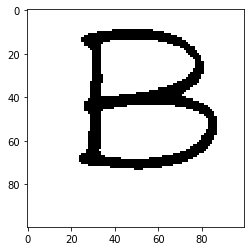

In [19]:
to_test = 17
y[to_test]
plt.imshow(X[to_test][:,:,0], cmap="gray")
print(LETS)

In [20]:
train_to_predict = X[to_test].reshape(-1, IMG_SIZE, IMG_SIZE, 1)
prediction = loaded_model.predict(X[to_test].reshape(-1, IMG_SIZE, IMG_SIZE, 1))
train_to_predict.shape
X[to_test].shape

prediction
np.argmax(prediction)
prediction[0][np.argmax(prediction)]
LETS[np.argmax(prediction)]

(1, 100, 100, 1)

(100, 100, 1)

array([[2.9088342e-15, 9.9999964e-01, 1.4687594e-15, 9.7669286e-09,
        2.9039816e-07, 2.4193119e-12, 8.9755350e-09, 4.3156902e-11,
        3.8347574e-19, 3.9690462e-20, 9.2967904e-19, 6.6747069e-25,
        2.0049615e-15, 1.9640285e-17, 8.6194607e-10, 1.4865350e-11,
        1.0829110e-18, 3.3944150e-11, 1.3706461e-08, 2.4464345e-12,
        3.3272135e-18, 1.5237502e-19, 3.4452083e-14, 4.2781096e-20,
        4.4830397e-22, 6.3538225e-10]], dtype=float32)

1

0.99999964

'B'

In [36]:
img = cv2.imread(os.path.join(testpath, test))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
resized = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
_, threshold = cv2.threshold(resized, 130, 255, cv2.THRESH_BINARY)

threshold = np.array(X[56]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

plt.imshow(X[56][:,:,0], cmap="gray")
cv2.imwrite("btest.png", X[56][:,:,0])
p = loaded_model.predict(threshold)
plt.title(p)
plt.show()
print(threshold.shape)

NameError: name 'testpath' is not defined

In [ ]:
img = load

(259, 267)
B.png
resized (100, 100)


Thresh (100, 100)
To predict (100, 100)
[[0. 0. 0. 0. 0. 0. 0. 1.]]


(186, 166)
A.png
resized (100, 100)


Thresh (100, 100)
To predict (100, 100)
[[0. 0. 0. 0. 0. 1. 0. 0.]]


(146, 157)
D.png
resized (100, 100)


Thresh (100, 100)
To predict (100, 100)
[[0. 0. 0. 0. 0. 0. 0. 1.]]


(139, 146)
C.png
resized (100, 100)


Thresh (100, 100)
To predict (100, 100)
[[0. 0. 0. 0. 0. 0. 0. 1.]]


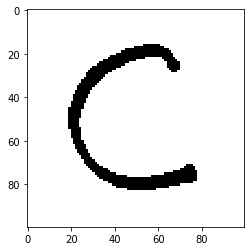

In [40]:
testpath = "../data/individual_abcd"
testimages = os.listdir(testpath)
for test in testimages:
    img = cv2.imread(os.path.join(testpath, test), 0)
    print(img.shape)
    print(test)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     print(gray.shape)

    resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    print("resized", resized.shape)

    _, threshold = cv2.threshold(resized, 120, 255, cv2.THRESH_BINARY)
    #resized = np.array(resized)
    plt.imshow(threshold, cmap="gray")
    print("Thresh", threshold.shape)
    
    to_predict = threshold.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    
    print("To predict", to_predict[0][:,:,0].shape)
    print(model.predict(to_predict))
    
    plt.imshow(to_predict[0][:,:,0], cmap="gray")
#     test_img = threshold.reshape(threshold.shape[0], threshold.shape[1], 1)
#     print("Test image", test_img.shape)
    
    
#     img_to_predict = test_img.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
#     print("to predict", img_to_predict.shape)
    
#     test2 = gray.reshape(-1, gray.shape[0], gray.shape[1], 1)
#     print(test2.shape)
# #     img_to_predict = threshold.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    
#     print("img_to_predict", img_to_predict.shape)
#     print(img_to_predict)
    
#     model.predict(img_to_predict)
    

#     plt.imshow(threshold, cmap="gray")
    
#     threshold = threshold.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
#     print("Thresh2", threshold.shape)
#     p = model.predict(threshold)
#     plt.title(p)
#     plt.show()

(100, 100, 1)

(100, 100)

(1, 100, 100, 1)

array([[0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

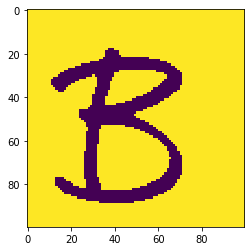

In [55]:
from PIL import Image
from keras.preprocessing import image
img_width, img_height = 100, 100

#'../data/individual_abcd/A.png'

img = image.load_img('btest.png', color_mode="grayscale", target_size=(img_width, img_height))
x = image.img_to_array(img)
x.shape
_, threshold = cv2.threshold(x[:,:,0], 120, 255, cv2.THRESH_BINARY)
threshold.shape
plt.imshow(threshold)
x = np.expand_dims(x, axis=0)
x.shape
images = np.vstack([x])

loaded_model.predict(images)
# classes = model.predict_classes(images, batch_size=10)
# print classes

(100, 100)

(1, 100, 100, 1)

(100, 100, 1)

(1, 100, 100, 1)

array([[0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

array([[0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

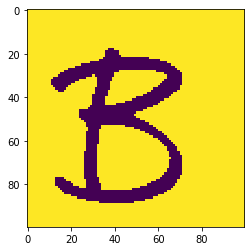

In [90]:

img = image.load_img('btest.png', color_mode="grayscale")
img = image.img_to_array(img)

_, threshold = cv2.threshold(img[:,:,0], 120, 255, cv2.THRESH_BINARY)
threshold.shape
img_to_predict = threshold.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
img_to_predict.shape
plt.imshow(threshold)

#img = cv2.imread('../data/individual_abcd/A.png', 0)
#img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
# img.shape
# img = img.reshape(img.shape[0], img.shape[1], 1)
img.shape
x = np.expand_dims(img, axis=0)
x.shape
loaded_model.predict(x)
loaded_model.predict(img_to_predict)